In [1]:
import graphein
graphein.verbose(enabled=False)
from graphein.protein.config import ProteinGraphConfig
from graphein.protein.graphs import construct_graph
from graphein.protein.features.nodes import amino_acid as graphein_nodes
from graphein.protein import edges as graphein_edges
from graphein.protein.subgraphs import extract_subgraph
from graphein.protein.visualisation import plotly_protein_structure_graph
from functools import partial
from matplotlib import colormaps

## Converting proteins to featurized graphs

The [graphein](https://graphein.ai/) library provides functionality for producing a number of types of graph-based representations of proteins. We'll use it to construct [NetworkX](https://github.com/networkx/networkx) graphs from protein structures, extract interface residues, and to featurise the nodes and edges of the graph

Here we use the node features implemented in `graphein.protein.features.nodes.amino_acid`, but there's many more kinds of node features available in the library (see the full [API](https://graphein.ai/modules/graphein.protein.html#features))

In [2]:
graph_config = ProteinGraphConfig(
    node_metadata_functions = [graphein_nodes.amino_acid_one_hot, graphein_nodes.meiler_embedding],
    edge_construction_functions = [graphein_edges.add_peptide_bonds, partial(graphein_edges.add_distance_threshold, 
                                                                             threshold=8., 
                                                                             long_interaction_threshold=2)]
)

In [3]:
graph = construct_graph(pdb_code='1A0G', config=graph_config)

Output()

Now we have a graph object consisting of nodes and edges, each associated with the attributes we've specified

In [4]:
i = 0
for (node, node_data) in graph.nodes(data=True):
  print("Node:", node)
  print("Node attributes:", node_data)
  if i > 5:
    break
  i += 1

Node: A:GLY:1
Node attributes: {'chain_id': 'A', 'residue_name': 'GLY', 'residue_number': 1, 'atom_type': 'CA', 'element_symbol': 'C', 'coords': array([62.54 , 19.333, 31.113]), 'b_factor': 26.2, 'amino_acid_one_hot': array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'meiler': dim_1    0.00
dim_2    0.00
dim_3    0.00
dim_4    0.00
dim_5    6.07
dim_6    0.13
dim_7    0.15
Name: GLY, dtype: float64}
Node: A:TYR:2
Node attributes: {'chain_id': 'A', 'residue_name': 'TYR', 'residue_number': 2, 'atom_type': 'CA', 'element_symbol': 'C', 'coords': array([60.403, 22.375, 31.908]), 'b_factor': 25.8, 'amino_acid_one_hot': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]), 'meiler': dim_1    2.94
dim_2    0.30
dim_3    6.47
dim_4    0.96
dim_5    5.66
dim_6    0.25
dim_7    0.41
Name: TYR, dtype: float64}
Node: A:THR:3
Node attributes: {'chain_id': 'A', 'residue_name': 'THR', 'residue_number': 3, 'atom_type': 'CA', 'element_symbol': 'C', 'coords': array([56.6

In [5]:
i = 0
for (start_node, end_node, edge_data) in graph.edges(data=True):
  print(f"Edge between {start_node} and {end_node}")
  print("Edge attributes:", edge_data)
  if i > 5:
    break
  i += 1

Edge between A:GLY:1 and A:TYR:2
Edge attributes: {'kind': {'peptide_bond'}, 'distance': 3.801652009324369}
Edge between A:GLY:1 and A:THR:3
Edge attributes: {'kind': {'distance_threshold'}, 'distance': 6.8811177871040705}
Edge between A:GLY:1 and A:LYS:11
Edge attributes: {'kind': {'distance_threshold'}, 'distance': 6.086497022097356}
Edge between A:GLY:1 and A:ASP:12
Edge attributes: {'kind': {'distance_threshold'}, 'distance': 5.909000084616683}
Edge between A:GLY:1 and A:ASN:80
Edge attributes: {'kind': {'distance_threshold'}, 'distance': 5.935047598798178}
Edge between A:TYR:2 and A:THR:3
Edge attributes: {'kind': {'peptide_bond'}, 'distance': 3.787657059449812}
Edge between A:TYR:2 and A:LEU:4
Edge attributes: {'kind': {'distance_threshold'}, 'distance': 6.882072071694685}


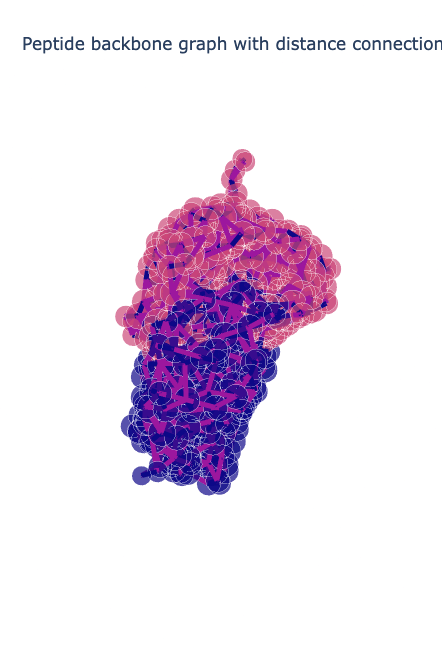

In [6]:
p = plotly_protein_structure_graph(
    graph,
    colour_edges_by="kind",
    colour_nodes_by='chain_id',
    label_node_ids=False,
    plot_title="Peptide backbone graph with distance connections.Nodes coloured by chain.",
    node_size_multiplier=1
    )
p.show()

We can extract interface residues from this graph by checking for edges between chains:

In [7]:
interface_residues = set()
for source, target, kind in graph.edges(data=True):
    if 'distance_threshold' in kind['kind'] and source.split(":")[0] == "A" and target.split(":")[0] != "A":
        interface_residues.add(source)
interface_residues

{'A:ALA:152',
 'A:ARG:138',
 'A:ARG:141',
 'A:ASN:148',
 'A:ASP:18',
 'A:ASP:28',
 'A:GLN:101',
 'A:GLN:157',
 'A:GLN:25',
 'A:GLY:151',
 'A:GLY:23',
 'A:GLY:27',
 'A:HIS:100',
 'A:HIS:160',
 'A:ILE:112',
 'A:ILE:137',
 'A:ILE:17',
 'A:ILE:58',
 'A:LEU:140',
 'A:LEU:147',
 'A:LEU:149',
 'A:LEU:150',
 'A:LEU:154',
 'A:LYS:156',
 'A:LYS:16',
 'A:LYS:19',
 'A:PHE:102',
 'A:PHE:26',
 'A:TRP:139',
 'A:TYR:24',
 'A:VAL:15',
 'A:VAL:153'}

This information can be added to the graph as an `interface_label` node feature:

In [8]:
for node, data in graph.nodes(data=True):
  if node in interface_residues:
    data['interface_label'] = 1
  else:
    data['interface_label'] = 0

Let's see where the interface is for this example:

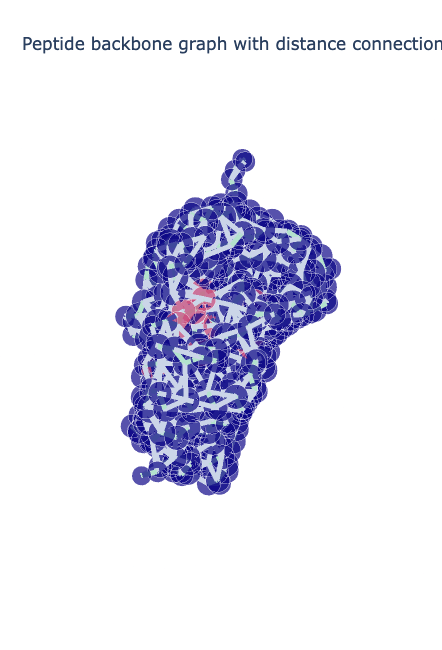

In [9]:
p = plotly_protein_structure_graph(
    graph,
    colour_edges_by='kind',
    colour_nodes_by='interface_label',
    label_node_ids=False,
    edge_color_map=colormaps['Pastel2'],
    plot_title="Peptide backbone graph with distance connections. Nodes coloured by interface labels.",
    node_size_multiplier=1
    )
p.show()

Since our task is to predict interface residues given just one input chain, we'll extract the subgraph for the chain of interest:

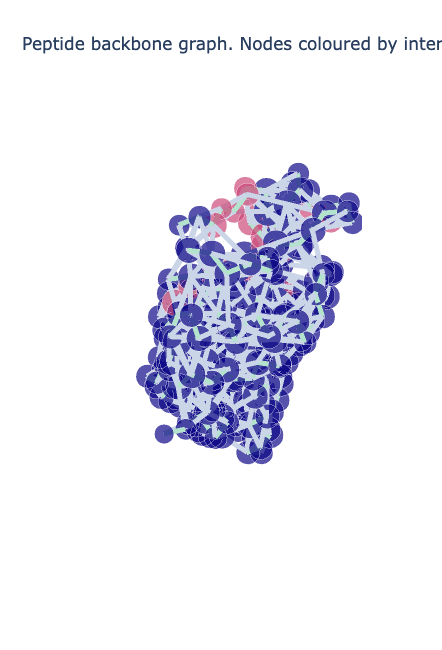

In [10]:
chain_subgraph = extract_subgraph(graph, chains="A")

p = plotly_protein_structure_graph(
    chain_subgraph,
    colour_edges_by="kind",
    colour_nodes_by="interface_label",
    label_node_ids=False,
    edge_color_map=colormaps['Pastel2'],
    plot_title="Peptide backbone graph. Nodes coloured by interface_label.",
    node_size_multiplier=1
    )
p.show()

We put all this together in a function to use in the later notebooks. Feel free to add other node features, edge types, and edge features to your function.

In [11]:
def load_graph(pdb_id, chain):
    graph_config = ProteinGraphConfig(
        node_metadata_functions = [graphein_nodes.amino_acid_one_hot, graphein_nodes.meiler_embedding],
        edge_construction_functions = [graphein_edges.add_peptide_bonds, 
                                       partial(graphein_edges.add_distance_threshold, 
                                               threshold=8.,
                                               long_interaction_threshold=2)],
    )
    graph = construct_graph(pdb_code=pdb_id, config=graph_config, verbose=False)
    interface_residues = set()
    for source, target, kind in graph.edges(data=True):
        c1, c2 = source.split(":")[0], target.split(":")[0]
        if 'distance_threshold' in kind['kind']:
            if c1 == chain and c2 != chain:
                interface_residues.add(source)
            elif c2 == chain and c1 != chain:
                interface_residues.add(target)
    graph = extract_subgraph(graph, chains=chain)
    for node, data in graph.nodes(data=True):
        if node in interface_residues:
            data['interface_label'] = 1
        else:
            data['interface_label'] = 0
    return graph

## Bonus


We can also add our own edge functions or node features that are not implemented in the graphein API. For example, we can calculate the solvent accessible surface area (SASA) for each residue and include it in as a node feature.

In [12]:
from Bio.PDB.mmtf import MMTFParser
from Bio.PDB.SASA import ShrakeRupley
import warnings
warnings.filterwarnings("ignore") # to ignore warnings when parsing pdb structures

def add_sasa(pdb_id, graph):
    struct = MMTFParser.get_structure_from_url(pdb_id)
    sr = ShrakeRupley()
    sr.compute(struct, level="R") # residue level
    for _, data in graph.nodes(data=True):
        # add SASA to node features
        data['sasa'] = struct[0][data['chain_id']][data['residue_number']].sasa
    return graph

graph = load_graph("1A0G", "A")
graph = add_sasa("1A0G", graph)

In [13]:
i = 0
for (node, node_data) in graph.nodes(data=True):
    print("Node:", node)
    print("Node attributes:", node_data)
    if i > 5:
        break
    i += 1

Node: A:ASP:207
Node attributes: {'chain_id': 'A', 'residue_name': 'ASP', 'residue_number': 207, 'atom_type': 'CA', 'element_symbol': 'C', 'coords': array([46.379, 27.722,  4.592]), 'b_factor': 18.7, 'amino_acid_one_hot': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'meiler': dim_1    1.60
dim_2    0.11
dim_3    2.78
dim_4   -0.77
dim_5    2.95
dim_6    0.25
dim_7    0.20
Name: ASP, dtype: float64, 'interface_label': 0, 'sasa': 30.699593145397}
Node: A:LYS:278
Node attributes: {'chain_id': 'A', 'residue_name': 'LYS', 'residue_number': 278, 'atom_type': 'CA', 'element_symbol': 'C', 'coords': array([66.801, 27.448,  8.101]), 'b_factor': 47.61, 'amino_acid_one_hot': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'meiler': dim_1    1.89
dim_2    0.22
dim_3    4.77
dim_4   -0.99
dim_5    9.99
dim_6    0.32
dim_7    0.27
Name: LYS, dtype: float64, 'interface_label': 0, 'sasa': 107.87544305228866}
Node: A:ASN:182
Node attributes: {'chain_id': 'A',

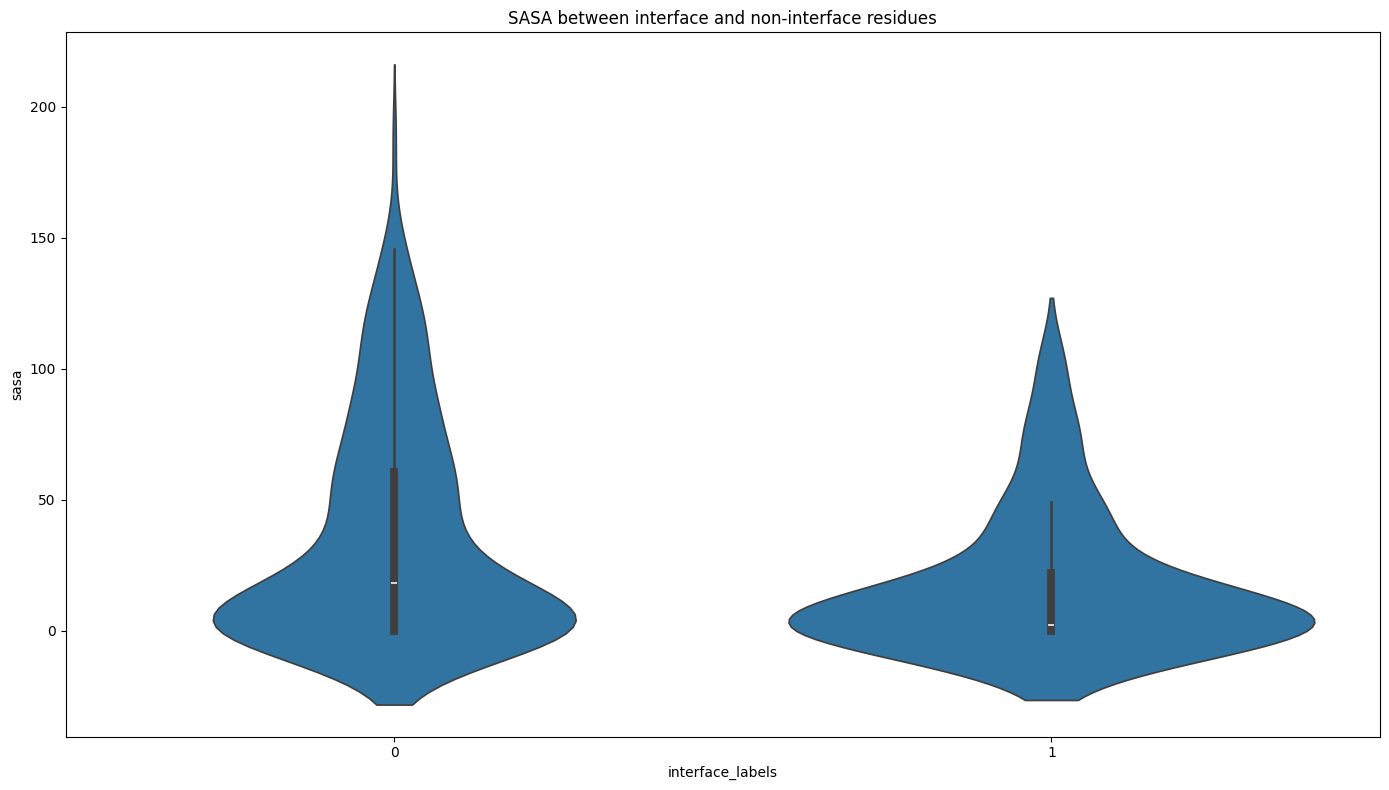

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sasa, interface_labels = [], []
for (node, node_data) in graph.nodes(data=True):
    sasa.append(node_data['sasa'])
    interface_labels.append(node_data['interface_label'])
data = {
    "sasa": sasa,
    "interface_labels": interface_labels
}

plt.figure(figsize=(14, 8))
sns.violinplot(x="interface_labels", y="sasa", data=data)
plt.title("SASA between interface and non-interface residues")
plt.tight_layout()
plt.show()

What other node or edge features would you like to include in your graph?